# Train and evaluate a PC

In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda")  # The device to use, e.g., "cpu", "cuda", "cuda:1"

Set the random seeds.

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if 'cuda' in device.type:
    torch.cuda.manual_seed(42)

## Load MNIST Dataset

Load the training and test splits of MNIST, and preprocess them by flattening the tensor images.

In [4]:
from torchvision import transforms, datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (255 * x.view(-1)).long())
])
data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)
num_variables = data_train[0][0].shape[0]
height, width = 28, 28
print(f"Number of variables: {num_variables}")

Number of variables: 784


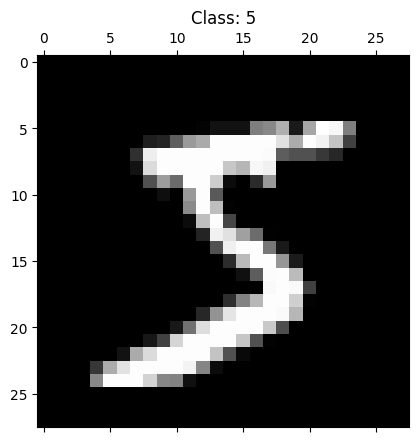

In [5]:
plt.matshow(data_train[0][0].reshape(28, 28), cmap='gray')
plt.title(f"Class: {data_train[0][1]}")
plt.show()

## Instantiating the region graph

Initialize a structured-decomposable _Quad Tree_ region graph.

In [6]:
from cirkit.region_graph.algorithms.quad_tree import QuadTree
region_graph = QuadTree(shape=(height, height), struct_decomp=True)

Others available region graphs are _Poon Domingos_ and _QuadTree_, whose imports are showed below.

In [7]:
from cirkit.region_graph.algorithms.poon_domingos import PoonDomingos
from cirkit.region_graph.algorithms.random_binary_tree import RandomBinaryTree

## Constructing the symbolic circuit representation

From the region graph definition above, we now initialize the symbolic circuit representation. To ensure weights are non-negative we reparametrize them via exponentiation. Several reparametrization functions are available in ```cirkit.reparams```.

In [8]:
from cirkit.symbolic import SymbolicTensorizedCircuit
from cirkit.layers import CPLayer, CategoricalLayer
from cirkit.utils.type_aliases import ReparamFactory, SymbLayerCfg
from cirkit.reparams import SoftmaxReparam, EFCategoricalReparam

In [9]:
sym_circuit = SymbolicTensorizedCircuit(
    region_graph,
    num_input_units=4,
    num_sum_units=4,
    input_cfg=SymbLayerCfg(layer_cls=CategoricalLayer, reparam_factory=EFCategoricalReparam,
                           layer_kwargs={'num_categories': 256}),
    sum_cfg=SymbLayerCfg(layer_cls=CPLayer, reparam_factory=SoftmaxReparam),
    prod_cfg=SymbLayerCfg(layer_cls=CPLayer))

## Building the tensorized PC

We finally build our tensorized PC using the symbolic representation described above.

In [10]:
from cirkit.models.tensorized_circuit import TensorizedCircuit
pc = TensorizedCircuit(sym_circuit)
pc.to(device)
print(pc)

TensorizedCircuit(
  (layers): ModuleList(
    (0): CategoricalLayer(
      (params): LogSoftmaxReparam(
        (reparams): ModuleList(
          (0): LeafReparam()
        )
      )
    )
    (1): DenseLayer(
      (params): SoftmaxReparam(
        (reparams): ModuleList(
          (0): LeafReparam()
        )
      )
    )
    (2): CategoricalLayer(
      (params): LogSoftmaxReparam(
        (reparams): ModuleList(
          (0): LeafReparam()
        )
      )
    )
    (3): DenseLayer(
      (params): SoftmaxReparam(
        (reparams): ModuleList(
          (0): LeafReparam()
        )
      )
    )
    (4): CategoricalLayer(
      (params): LogSoftmaxReparam(
        (reparams): ModuleList(
          (0): LeafReparam()
        )
      )
    )
    (5): DenseLayer(
      (params): SoftmaxReparam(
        (reparams): ModuleList(
          (0): LeafReparam()
        )
      )
    )
    (6): CategoricalLayer(
      (params): LogSoftmaxReparam(
        (reparams): ModuleList(
        

## Training and testing

We are now ready to learn the parameters. First, we wrap our data into PyTorch data loaders by specifying the batch size. Then, we initialize any PyTorch optimizer, e.g. SGD with momentum in this case.

In [11]:
from torch import optim
from torch.utils.data import DataLoader
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)
optimizer = optim.SGD(pc.parameters(), lr=0.1, momentum=0.9)

Finally, we optimize the parameters by minimizing the negative log-likelihood.

In [12]:
num_epochs = 1
for epoch_idx in range(num_epochs):
    running_loss = 0.0
    for i, (batch, _) in enumerate(train_dataloader):
        batch = batch.to(device).unsqueeze(dim=-1)  # Add a channel dimension
        lls = pc(batch)
        loss = -torch.mean(lls)   # The loss is the negative average log-likelihood
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.detach() * len(batch)
        if (i + 1) % 10 == 0:
            print(f"Step {i + 1}: Average NLL: {running_loss / (10 * len(batch)):.3f}")
            running_loss = 0.0
        if i == 99:
            break

Step 10: Average NLL: 4080.895
Step 20: Average NLL: 2287.874
Step 30: Average NLL: 1274.941
Step 40: Average NLL: 1089.504
Step 50: Average NLL: 1036.416
Step 60: Average NLL: 1006.071
Step 70: Average NLL: 978.195
Step 80: Average NLL: 957.326
Step 90: Average NLL: 938.135
Step 100: Average NLL: 940.275


We then evaluate our model on test data by computing the average log-likelihood and bits per dimension.

In [14]:
with torch.no_grad():
    pc.eval()
    test_lls = 0.0
    for batch, _ in test_dataloader:
        lls = pc(batch.to(device).unsqueeze(dim=-1))
        test_lls += lls.sum().item()
    average_ll = test_lls / len(data_test)
    bpd = -average_ll / (num_variables * np.log(2.0))
    print(f"Average test LL: {average_ll:.3f}")
    print(f"Bits per dimension: {bpd}")

Average test LL: -925.921
Bits per dimension: 1.7038545107852952
